In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SequentialFeatureSelector
df =pd.read_csv("Bourse.dat", sep="|", names=['data'])
df = df['data'].str.split(n=20, expand=True)
df=df.astype(float)
df -= df.min()
df /= df.max()
featureList=[10, 11, 16]
data=df.to_numpy()
np.random.shuffle(data)
X=np.delete(data,[f for f in range(21) if f not in featureList],axis=1)
y=np.array(data[:,20], dtype=np.int8)
Xtrain=X[:120]
Xtest=X[120:]
Ytrain=y[:120]
Ytest=y[120:]

In [ ]:
def make_confusion_matrix(y_true, y_pred,plotTitle="Confusion Matrix", classes=None, figsize=(8, 8), text_size=15, norm=False, savefig=False): 

  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title=plotTitle,
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png",dpi=100)


In [ ]:
def performanceDetails(Ytrain,result):
  confusion=confusion_matrix(Ytrain,result)
  accuracy=(confusion[1][1]+confusion[0][0])/np.sum(confusion)
  percision=confusion[1][1]/(confusion[1][1]+confusion[1][0])
  recall=confusion[1][1]/(confusion[1][1]+confusion[0][1])
  F1=2*confusion[1][1]/(2*confusion[1][1]+confusion[0][1]+confusion[1][0])
  return accuracy,percision,recall,F1

In [ ]:
class FuzzyClassifier:
  def __init__(self):
    self.fuzzifiers_zigma=tf.Variable([[1],[1],[1],[1],[1],[1]],dtype=tf.float32)
    self.fuzzifiers_center=tf.Variable(tf.random.uniform([6,1],minval=0,maxval=1),dtype=tf.float32)
    self.weiths=tf.Variable(tf.random.uniform([8,1],minval=-1,maxval=1),dtype=tf.float32)
  def gaussian(self,x,center,sigma):
    return tf.divide(tf.exp(-tf.pow(tf.subtract(center,x),2)),sigma)
  def feedforward(self,X):
    mu=self.gaussian(X,self.fuzzifiers_center,self.fuzzifiers_zigma)
    t1=tf.multiply(tf.multiply(mu[0],mu[1]),mu[2])
    t2=tf.multiply(tf.multiply(mu[0],mu[1]),mu[5])
    t3=tf.multiply(tf.multiply(mu[0],mu[4]),mu[2])
    t4=tf.multiply(tf.multiply(mu[0],mu[4]),mu[5])
    t5=tf.multiply(tf.multiply(mu[3],mu[1]),mu[2])
    t6=tf.multiply(tf.multiply(mu[3],mu[1]),mu[5])
    t7=tf.multiply(tf.multiply(mu[3],mu[4]),mu[2])
    t8=tf.multiply(tf.multiply(mu[3],mu[4]),mu[5])
    tSum=tf.add(t1,tf.add(t2,tf.add(t3,tf.add(t4,tf.add(t5,tf.add(t6,tf.add(t7,t8)))))))
    t1=tf.divide(t1,tSum)
    t2=tf.divide(t2,tSum)
    t3=tf.divide(t3,tSum)
    t4=tf.divide(t4,tSum)
    t5=tf.divide(t5,tSum)
    t6=tf.divide(t6,tSum)
    t7=tf.divide(t7,tSum)
    t8=tf.divide(t8,tSum)
    return tf.add(tf.multiply(t1,self.weiths[0]),
                  tf.add(tf.multiply(t2,self.weiths[1]),
                  tf.add(tf.multiply(t3,self.weiths[2]),
                  tf.add(tf.multiply(t4,self.weiths[3]),
                  tf.add(tf.multiply(t5,self.weiths[4]),
                  tf.add(tf.multiply(t6,self.weiths[5]),
                  tf.add(tf.multiply(t7,self.weiths[6]),
                  tf.multiply(t8,self.weiths[7]))))))))
  def predict(self,X):
    result=self.feedforward(X)
    result=result.numpy()
    result[result>=0.5]=1
    result[result<0.5]=0
    return result
  def train(self,X,Y,epoch,lr=0.005,detail=False):
    for i in range(epoch):
      with tf.GradientTape() as tape:
        cost=tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=self.feedforward(X))
        gradients=tape.gradient(cost,[self.fuzzifiers_center,self.fuzzifiers_zigma,self.weiths])
        self.fuzzifiers_center.assign_sub(gradients[0]*lr)
        self.fuzzifiers_zigma.assign_sub(gradients[1]*lr)
        self.weiths.assign_sub(gradients[2]*lr)
      if (i%50)==0 and detail:
        lr*=0.9
        print(f"epoch:{i}  loss:",np.sum(cost.numpy()),f" lr:{lr}")

In [ ]:
fModel=FuzzyClassifier()
fModel.train(np.tile(Xtrain.T, (2, 1)),np.array(Ytrain,dtype=np.float32),2000,detail=True)

epoch:0  loss: 84.20781  lr:0.0045000000000000005
epoch:50  loss: 80.96646  lr:0.004050000000000001
epoch:100  loss: 76.77348  lr:0.0036450000000000007
epoch:150  loss: 69.740524  lr:0.003280500000000001
epoch:200  loss: 62.612083  lr:0.002952450000000001
epoch:250  loss: 56.28959  lr:0.002657205000000001
epoch:300  loss: 49.982548  lr:0.002391484500000001
epoch:350  loss: 47.23297  lr:0.002152336050000001
epoch:400  loss: 53.821205  lr:0.001937102445000001
epoch:450  loss: 51.198486  lr:0.001743392200500001
epoch:500  loss: 50.253883  lr:0.001569052980450001
epoch:550  loss: 42.592686  lr:0.0014121476824050009
epoch:600  loss: 42.08398  lr:0.0012709329141645008
epoch:650  loss: 46.49839  lr:0.0011438396227480508
epoch:700  loss: 41.28631  lr:0.0010294556604732458
epoch:750  loss: 39.740074  lr:0.0009265100944259213
epoch:800  loss: 40.598087  lr:0.0008338590849833291
epoch:850  loss: 42.44212  lr:0.0007504731764849962
epoch:900  loss: 41.799534  lr:0.0006754258588364966
epoch:950  los

for Train Data accuracy:0.8916666666666667 percision:0.85 recall:0.9272727272727272 F1:0.8869565217391304


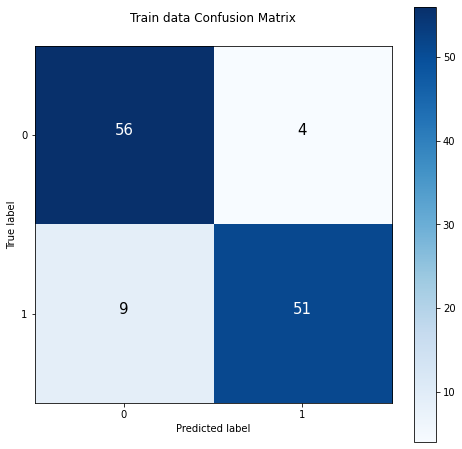

In [ ]:
result=fModel.predict(np.tile(Xtrain.T, (2, 1)))
make_confusion_matrix(Ytrain,result,plotTitle="Train data Confusion Matrix")
accuracy,percision,recall,F1=performanceDetails(Ytrain,result)
print(f"for Train Data accuracy:{accuracy} percision:{percision} recall:{recall} F1:{F1}")

for Test Data accuracy:0.8695652173913043 percision:0.9166666666666666 recall:0.8461538461538461 F1:0.88


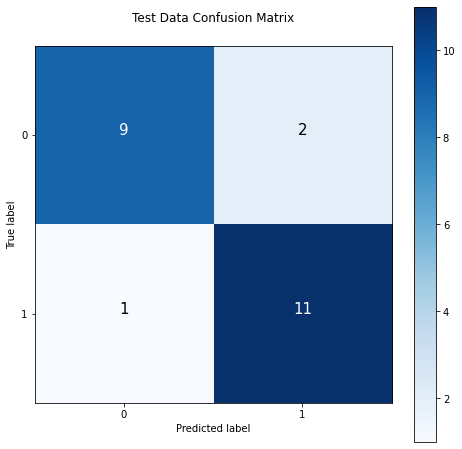

In [ ]:
result=fModel.predict(np.tile(Xtest.T, (2, 1)))
make_confusion_matrix(Ytest,result,plotTitle="Test Data Confusion Matrix")
accuracy,percision,recall,F1=performanceDetails(Ytest,result)
print(f"for Test Data accuracy:{accuracy} percision:{percision} recall:{recall} F1:{F1}")
